## Zadanie

Załóżmy, że chcemy kupić mieszkanie. Do dyspozycji mamy 100 000 dolarów, możemy też wziąć kredyt na kolejne 250 tysięcy, co da nam w sumie budżet w wysokości 350 000 dolarów.

**Chcemy móc przewidzieć, czy mieszkanie o pewnych, zadanych parametrach, możemy kupić za własne pieniądze (cheap), z kredytem (average), czy jest poza naszym zasięgiem (expensive).**

Klasy:
- 0 - cheap <100 000
- 1 - average (100 000; 350 000)
- 2 - expensive >350 000

W oparciu o dostępne atrybuty zbuduj model, który pomoże oszacować, czy dana nieruchomość należy do klasy cheap, average czy expensive. Do dyspozycji mają Państwo dane treningowe (train_data.csv) z oryginalnymi cenami nieruchomości (SalePrice), oraz, tak jak ostatnio, zbiór testowy (test_data.csv).
Proszę przygotować kod, który pozwoli na uzyskanie DOKŁADNIE tych samych predykcji, które zostały dołączone w pliku wynikowym. W tym celu proszę zadbać o odpowiednie seedy losowych modułów itp.

W ramach rozwiązania, proszę oddać poprzez Teamsy plik - archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze test_data.csv.
W pliku z predykcjami powinna się znajdować dokładnie jedna kolumna, oznaczająca przewidywaną przez Państwa klasę ceny mieszkania (0 <- cheap, 1 <- average, 2 <- expensive).
Końcowe wyniki obliczał będę w oparciu o średnią dokładność dla każdej klasy. Proszę zwrócić uwagę na fakt, że klasy są mocno niezbalansowane!
Koniecznie proszę sprawdzić format zwracanych przez Państwa predykcji (tyle predykcji ile elementów w zbiorze testowym, brak nagłówków, jedna kolumna, itd.)
Bardzo proszę nazywać wszystkie pliki nazwiskami autorów (najlepiej alfabetycznie), lub nazwą zespołu. Nazwę głównego archiwum zip proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_ (nie pon/pia), proszę też nie umieszczać plików w dodatkowych podfolderach tylko bezpośrednio .
W MS Teams wszystkim przydzieliłem zadanie, ale bardzo proszę, żeby tylko jeden (dowolny) członek zespołu je zwrócił.
W razie pytań zapraszam do korespondencji lub na konsultacje.


## Import bibliotek

In [997]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [998]:
seed = 50

torch.manual_seed(seed)
np.random.seed(seed)

## Helper functions

- Saving data

In [999]:
def save_to_csv(numpy_array: np.ndarray, filename: str):
    np.savetxt(filename, numpy_array, delimiter=",", fmt='%1d')

In [1000]:
def determine_class(price: int):
    if price < 100_000:
        return 0
    elif 100_000 <= price <= 350_000:
        return 1
    else:
        return 2

## Loading data

In [1001]:
train_data = 'train_data.csv'
test_data = 'test_data.csv'

In [1002]:
df = pd.read_csv(train_data)
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


In [1003]:
df.shape

(4124, 17)

In [1004]:
sale_price_division_factor = 100_000

In [1005]:
df['SalePrice'].apply(determine_class).value_counts()

1    2998
2     570
0     556
Name: SalePrice, dtype: int64

In [1006]:
df['SalePrice'].describe()

count      4124.000000
mean     222177.477207
std      106325.535526
min       34070.000000
25%      144752.000000
50%      209588.000000
75%      291570.000000
max      585840.000000
Name: SalePrice, dtype: float64

In [1007]:
(df['SalePrice'] / sale_price_division_factor).describe()

count    4124.000000
mean        2.221775
std         1.063255
min         0.340700
25%         1.447520
50%         2.095880
75%         2.915700
max         5.858400
Name: SalePrice, dtype: float64

In [1008]:
df['SalePrice'] = df['SalePrice'] / sale_price_division_factor

### Splitting data

In [1011]:
val_set_factor = 0.2

df_val = df.sample(frac=val_set_factor)
df_train = df.drop(df_val.index)

In [1012]:
df_train.shape, df_val.shape

((3299, 17), (825, 17))

## EDA

In [1013]:
df_train.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1.41592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,0.51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,0.48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
4,0.78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
5,0.61946,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0


In [1014]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3299 entries, 0 to 4123
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SalePrice                  3299 non-null   float64
 1   YearBuilt                  3299 non-null   int64  
 2   Size(sqf)                  3299 non-null   int64  
 3   Floor                      3299 non-null   int64  
 4   HallwayType                3299 non-null   object 
 5   HeatingType                3299 non-null   object 
 6   AptManageType              3299 non-null   object 
 7   N_Parkinglot(Ground)       3299 non-null   float64
 8   N_Parkinglot(Basement)     3299 non-null   float64
 9   TimeToBusStop              3299 non-null   object 
 10  TimeToSubway               3299 non-null   object 
 11  N_manager                  3299 non-null   float64
 12  N_elevators                3299 non-null   float64
 13  SubwayStation              3299 non-null   objec

In [1015]:
df_train.describe()

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000,3299.000000
mean,2.228831,2003.103668,961.525614,12.006366,190.444074,574.408002,6.318278,10.991816,5.838739,9.828736,10.780540
std,1.074271,8.663939,383.237131,7.633924,214.929484,408.451833,3.262324,7.664880,2.345415,3.441984,4.430143
min,0.340700,1978.000000,135.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,1.442470,1993.000000,644.000000,6.000000,8.000000,184.000000,5.000000,5.000000,4.000000,8.000000,7.000000
50%,2.097340,2006.000000,910.000000,11.000000,90.000000,536.000000,6.000000,11.000000,5.000000,9.000000,10.000000
75%,2.946900,2008.000000,1160.000000,17.000000,249.000000,798.000000,8.000000,16.000000,7.000000,13.000000,15.000000
max,5.858400,2015.000000,2337.000000,43.000000,713.000000,1321.000000,14.000000,27.000000,10.000000,16.000000,17.000000


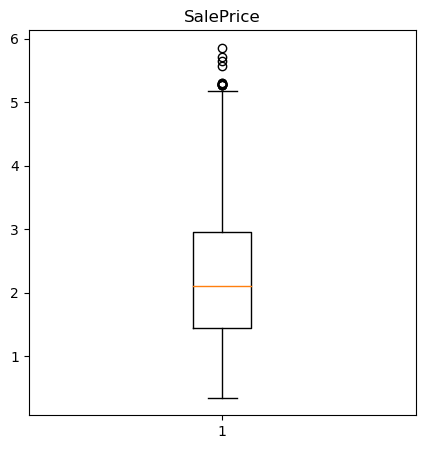

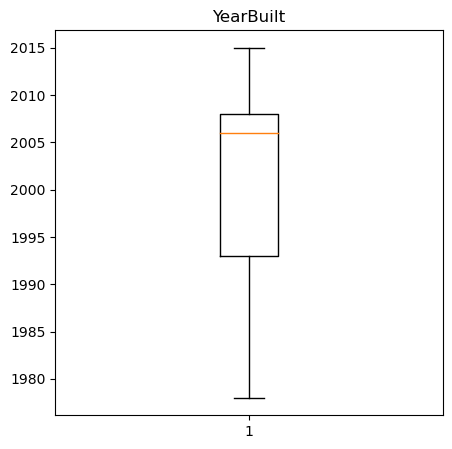

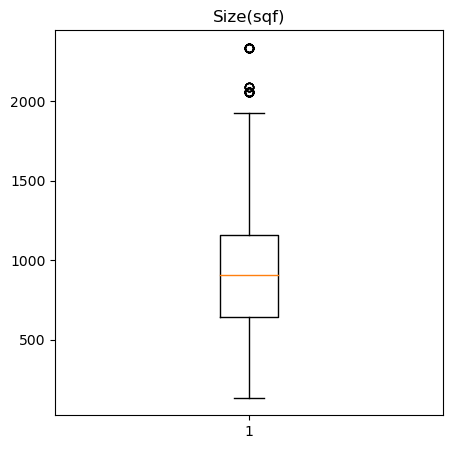

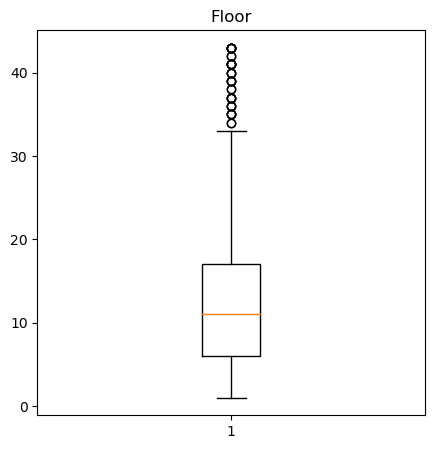

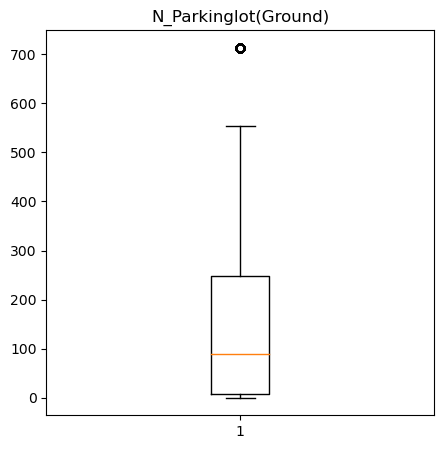

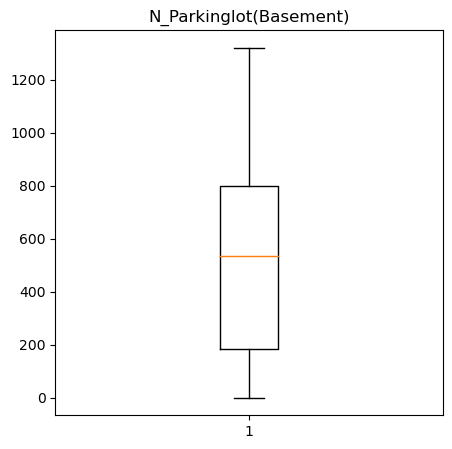

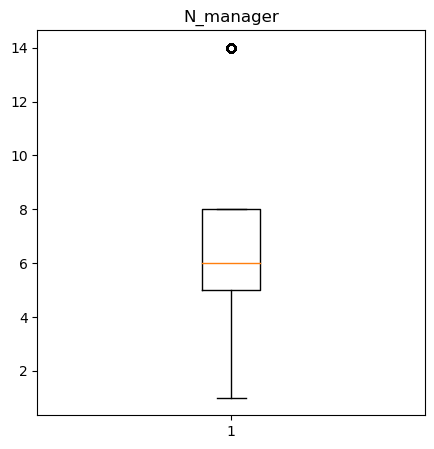

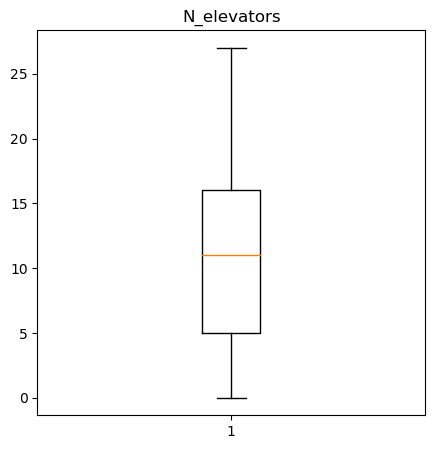

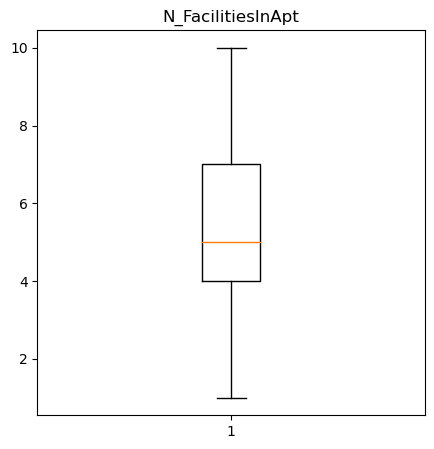

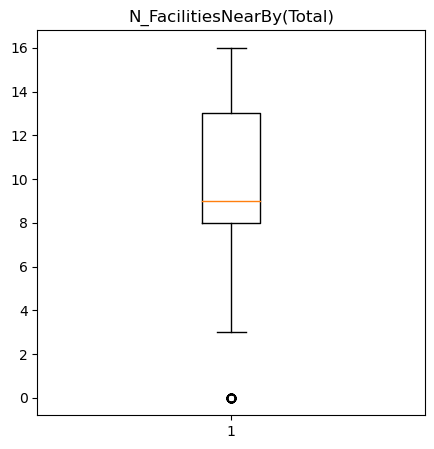

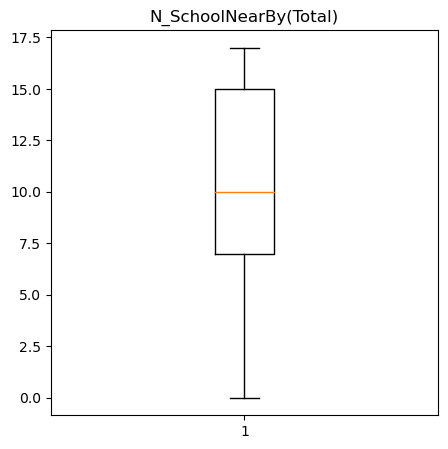

In [1016]:
for col in df_train._get_numeric_data().columns:
    plt.figure(figsize=(5, 5))
    plt.boxplot(df_train[col])
    plt.title(col)

plt.show()

The dataset seems not to contain any significant outliers

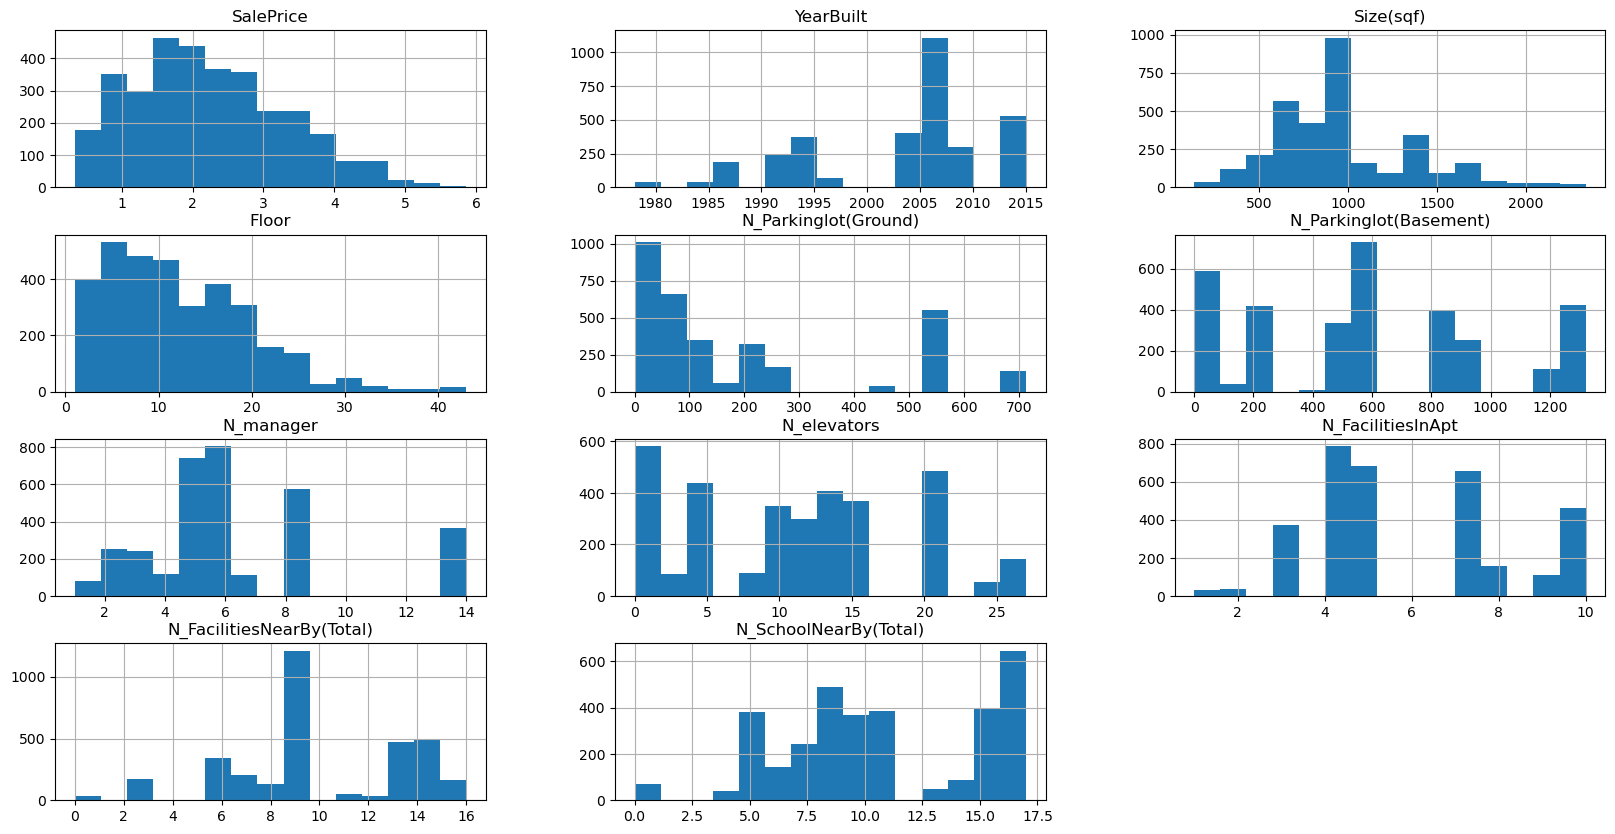

In [1017]:
df_train.hist(figsize=(20, 10), bins=15)
plt.show()

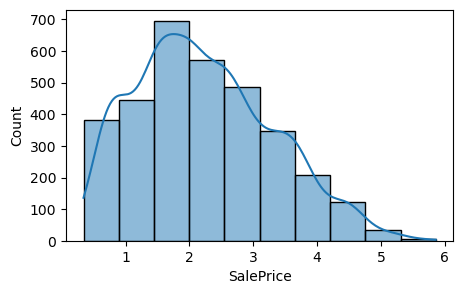

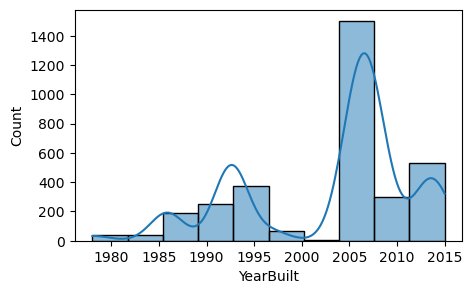

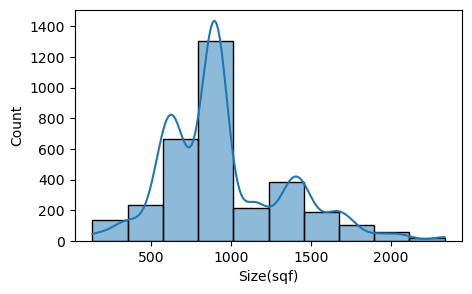

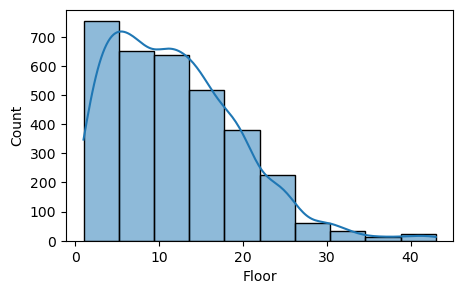

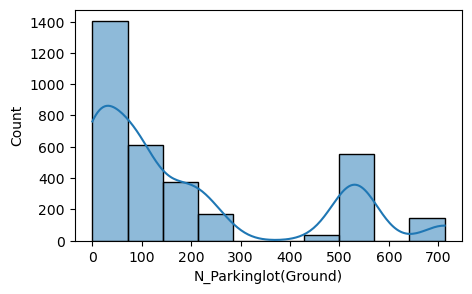

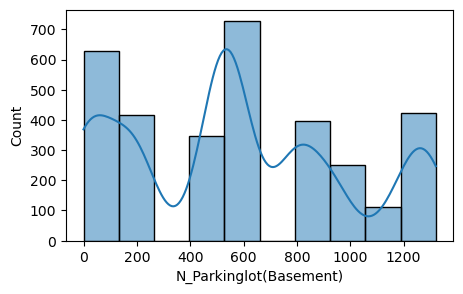

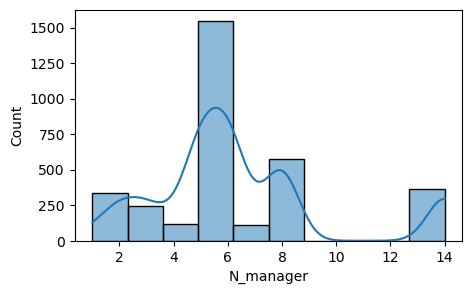

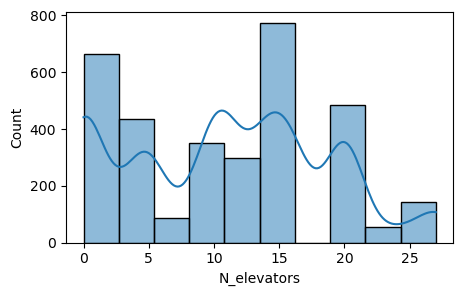

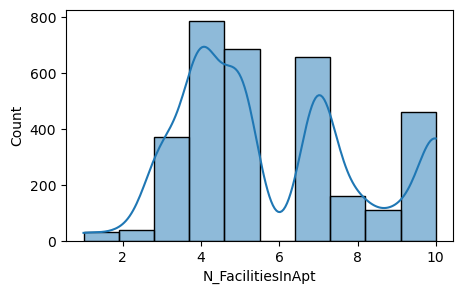

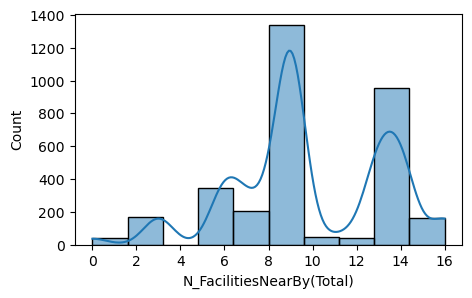

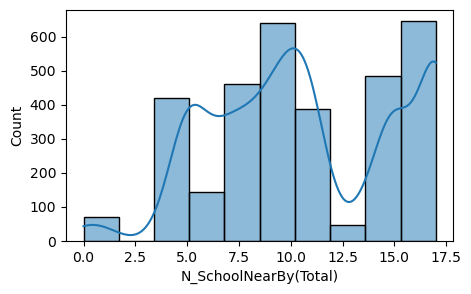

In [1018]:
for col in df_train._get_numeric_data().columns:
    plt.figure(figsize=(5, 3))
    sns.histplot(data=df_train, x=col, kde=True, bins=10)

## Dividing data into features and labels

- Train

In [1019]:
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice'].values #.reshape(-1, 1)

X_train.shape, y_train.shape

((3299, 16), (3299,))

In [1020]:
y_train = torch.tensor([determine_class(label * sale_price_division_factor) for label in y_train], dtype=torch.long)

<AxesSubplot: ylabel='Count'>

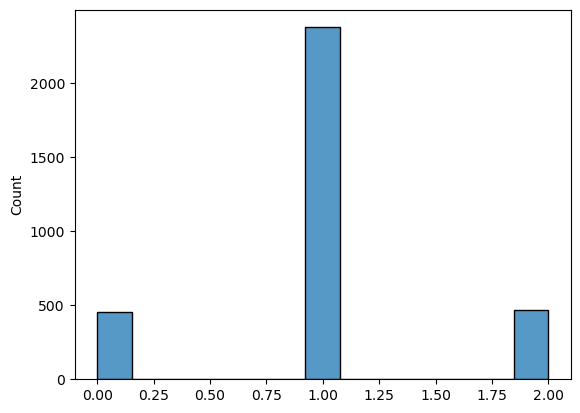

In [1021]:
sns.histplot(y_train)

- Val

In [1022]:
X_val = df_val.drop('SalePrice', axis=1)
y_val = df_val['SalePrice'].values #.reshape(-1, 1)

X_val.shape, y_val.shape

((825, 16), (825,))

In [1023]:
y_val = torch.tensor([determine_class(label * sale_price_division_factor) for label in y_val], dtype=torch.long)

<AxesSubplot: ylabel='Count'>

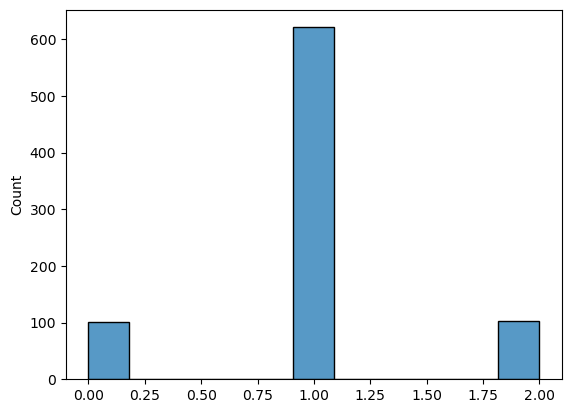

In [1024]:
sns.histplot(y_val)

## Preprocessing

In [1025]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]

- ### Scaling

In [1026]:
numeric_columns = X_train._get_numeric_data().columns
numeric_columns

Index(['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)', 'N_manager', 'N_elevators',
       'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)',
       'N_SchoolNearBy(Total)'],
      dtype='object')

In [1027]:
scaling_pipeline = Pipeline([
    ('numeric_cols_selector', FeatureSelector(numeric_columns)),
    ('scaler', StandardScaler())
])

- ### Encoding values

In [1028]:
X_train.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
5,1993,644,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0


In [1029]:
feature_encoder = OrdinalEncoder()

- ### One Hot Encoding

In [1030]:
class DataFrameOneHotEncoder:
    def __init__(self, columns=None) -> None:
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.transform(X, y)
    
    def transform(self, X, y=None):
        X_transformed = pd.get_dummies(X, columns=self.columns)
        return X_transformed


class ColumnDropper:
    def __init__(self, columns) -> None:
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.transform(X, y)
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)


In [1031]:
one_hot_encoder = DataFrameOneHotEncoder(columns=['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation'])

## Pipeline

In [1033]:
replaced_columns = ['TimeToBusStop', 'TimeToSubway'] + list(X_train._get_numeric_data().columns)

In [1034]:
feature_encoder_pipeline = Pipeline([
    ('feature_selector', FeatureSelector(columns=['TimeToBusStop', 'TimeToSubway'])),
    ('feature_encoder', OrdinalEncoder())
])


ohe_pipeline = Pipeline([
    ('column_dropper', ColumnDropper(columns=replaced_columns)),
    ('data_frame_ohe', DataFrameOneHotEncoder(columns=['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']))
])


transformation_pipeline = FeatureUnion([
    ('scaling_pipeline', scaling_pipeline),
    ('feature_encoder_pipeline', feature_encoder_pipeline),
    ('ohe_pipeline', ohe_pipeline)
])

- Train

In [1035]:
X_train_prep = transformation_pipeline.fit_transform(X_train, y_train)

In [1036]:
X_train.iloc[-15, :]

YearBuilt                                   2005
Size(sqf)                                    572
Floor                                         20
HallwayType                                mixed
HeatingType                   individual_heating
AptManageType                management_in_trust
N_Parkinglot(Ground)                        67.0
N_Parkinglot(Basement)                     798.0
TimeToBusStop                             0~5min
TimeToSubway                          5min~10min
N_manager                                    6.0
N_elevators                                  0.0
SubwayStation                            Bangoge
N_FacilitiesInApt                              7
N_FacilitiesNearBy(Total)                   13.0
N_SchoolNearBy(Total)                       15.0
Name: 4106, dtype: object

In [1037]:
X_train.select_dtypes(object).nunique()

HallwayType      3
HeatingType      2
AptManageType    2
TimeToBusStop    3
TimeToSubway     5
SubwayStation    8
dtype: int64

In [1038]:
X_train_prep[-15]

array([ 0.21890963, -1.01656294,  1.04727875, -0.57443393,  0.54749636,
       -0.09757662, -1.43426665,  0.49519461,  0.92148745,  0.95258769,
        0.        ,  3.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

- Val

In [1039]:
X_val_prep = transformation_pipeline.transform(X_val)

In [1040]:
X_train_prep.shape

(3299, 27)

## Oversampling - handling imbalanced data

In [1041]:
oversampler = RandomOverSampler(sampling_strategy={0: 800, 1: 2661, 2: 700}, random_state=seed)

In [1042]:
X_train_prep, y_train = oversampler.fit_resample(X_train_prep, y_train)

X_train_prep = torch.tensor(X_train_prep, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)

## Training

In [1044]:
input_features = X_train_prep.shape[1]
input_features

27

### Dataset

In [1046]:
train_numeric_data = torch.tensor(X_train_prep[:, :10], dtype=torch.float)
train_time_data = torch.tensor(X_train_prep[:, 10:12], dtype=torch.float)
train_categorical_data = torch.tensor(X_train_prep[:, 12:-8], dtype=torch.float)
train_station_data = torch.tensor(X_train_prep[:, -8:], dtype=torch.float)

val_numeric_data = torch.tensor(X_val_prep[:, :10], dtype=torch.float)
val_time_data = torch.tensor(X_val_prep[:, 10:12], dtype=torch.float)
val_categorical_data = torch.tensor(X_val_prep[:, 12:-8], dtype=torch.float)
val_station_data = torch.tensor(X_val_prep[:, -8:], dtype=torch.float)

In [1047]:
input_numeric_features = train_numeric_data.shape[1]
num_categorical_features = train_categorical_data.shape[1]
num_time_features = train_time_data.shape[1]
num_station_features = train_station_data.shape[1]
output_size = 3

In [1048]:
train_dataset = TensorDataset(train_numeric_data, train_categorical_data, train_time_data, train_station_data, y_train)

val_dataset = TensorDataset(val_numeric_data, val_categorical_data, val_time_data, val_station_data, y_val)

### Dataloader

In [1157]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=128)

### Model

In [1311]:
class PredictionModel(nn.Module):
    def __init__(self, input_numeric_features, num_categorical_features, num_time_features, num_station_features, output_size, device='cpu') -> None:
        super().__init__()
        self.device = device
        self.embedding = nn.Linear(num_categorical_features, num_categorical_features)
        self.time_embedding = nn.Linear(num_time_features, num_time_features)
        self.station_embedding = nn.Linear(num_station_features, num_station_features)
        self.act_embedding = nn.Tanh()
        self.act_time_embedding = nn.Tanh()
        self.act_station_embedding = nn.Tanh()
        
        num_embedding_features = input_numeric_features + num_categorical_features + num_time_features + num_station_features
        self.combine_input_layer = nn.Linear(num_embedding_features, 1024)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        self.output_layer = nn.Linear(128, output_size)
    
    def forward(self, X, X_categorical, X_time, X_station):
        X_cat_embedded = self.embedding(X_categorical)
        X_cat_embedded = self.act_embedding(X_categorical)
        
        X_time_embedded = self.time_embedding(X_time)
        X_time_embedded = self.act_time_embedding(X_time_embedded)
        
        X_station_embedded = self.station_embedding(X_station)
        X_station_embedded = self.act_station_embedding(X_station_embedded)
        
        X = torch.cat([X, X_cat_embedded, X_time_embedded, X_station_embedded], dim=1)
        
        X = self.combine_input_layer(X)
        X = self.linear_relu_stack(X)

        return self.output_layer(X)
    
    def predict(self, X, X_categorical, X_time, X_station_embedded):
        y_pred = self.forward(X, X_categorical, X_time, X_station_embedded)
        return [int(torch.argmax(pred)) for pred in y_pred]
    
    def fit(self, train_dataloader, loss_func, optimizer, epochs, val_dataloader=None):
        train_report = {
            'train_loss_history': []
        }
        
        if val_dataloader is not None:
            train_report['val_loss_history'] = []
        
        self.train()
        for epoch in range(epochs):
            train_epoch_loss = self._train_one_epoch(train_dataloader, loss_func, optimizer)
              
            avg_epoch_loss = train_epoch_loss / len(train_dataloader)
            train_report['train_loss_history'].append(avg_epoch_loss)
            print('================================')
            print(f'Epoch: {epoch}, Train Loss: {avg_epoch_loss}')
            
            if val_dataloader is not None:
                val_loss = self.perform_validation(val_dataloader, loss_func)
                train_report['val_loss_history'].append(val_loss)
                print(f'Val Loss: {val_loss}')
            
        return train_report

    def perform_validation(self, validation_dataloader, loss_func):
        val_loss = 0.0
        with torch.no_grad():
            for numeric_sample_batch, cat_sample_batch, time_sample_batch, station_sample_batch, label_batch in validation_dataloader:
                X = numeric_sample_batch.to(self.device)
                X_cat = cat_sample_batch.to(self.device)
                X_time = time_sample_batch.to(self.device)
                X_station = station_sample_batch.to(self.device)
                y = label_batch.to(self.device)
                
                y_pred = self.forward(X, X_cat, X_time, X_station)
                loss = loss_func(y_pred, y)
                val_loss += loss.item()
            
            avg_val_loss = val_loss / len(validation_dataloader)
        return avg_val_loss

    def _train_one_epoch(self, train_dataloader, loss_func, optimizer):
        train_epoch_loss = 0.0
        for numeric_sample_batch, cat_sample_batch, time_sample_batch, station_sample_batch, label_batch in train_dataloader:
                X = numeric_sample_batch.to(self.device)
                X_cat = cat_sample_batch.to(self.device)
                X_time = time_sample_batch.to(self.device)
                X_station = station_sample_batch.to(self.device)
                y = label_batch.to(self.device)
                
                y_pred = self.forward(X, X_cat, X_time, X_station)
                loss = loss_func(y_pred, y)
                train_epoch_loss += loss.item()
                
                self._optimize_params(loss, optimizer)
        return train_epoch_loss
    
    def _optimize_params(self, loss, optimizer):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    def _determine_class(self, price: int):
        if price < 100_000:
            return 0
        elif 100_000 <= price <= 350_000:
            return 1
        else:
            return 2

In [1312]:
model = PredictionModel(input_numeric_features, num_categorical_features, num_time_features, num_station_features, output_size)

Sample weighting

In [1313]:
class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique().numpy(), y=y_train.numpy())
# class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = torch.tensor([1, 1, 1.5], dtype=torch.float)
class_weights

tensor([1.0000, 1.0000, 1.5000])

Optimizer and Criterion

In [1314]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss(weight=class_weights) # weight=class_weights

In [1315]:
train_report = model.fit(train_dataloader, loss_func, optimizer, epochs=50, val_dataloader=val_dataloader)

Epoch: 0, Train Loss: 0.6976885394408152
Val Loss: 0.4135040215083531
Epoch: 1, Train Loss: 0.4053013508136456
Val Loss: 0.3321540973016194
Epoch: 2, Train Loss: 0.37107756390021396
Val Loss: 0.3421687143189566
Epoch: 3, Train Loss: 0.3611311843762031
Val Loss: 0.32848553146634785
Epoch: 4, Train Loss: 0.34738492851073927
Val Loss: 0.3174039466040475
Epoch: 5, Train Loss: 0.34502048790454865
Val Loss: 0.328838118485042
Epoch: 6, Train Loss: 0.33593916778381055
Val Loss: 0.33633413910865784
Epoch: 7, Train Loss: 0.3367414382787851
Val Loss: 0.3125665656157902
Epoch: 8, Train Loss: 0.334978848695755
Val Loss: 0.3121756102357592
Epoch: 9, Train Loss: 0.3330564516095015
Val Loss: 0.30164773549352375
Epoch: 10, Train Loss: 0.326164580308474
Val Loss: 0.31473247494016376
Epoch: 11, Train Loss: 0.3242196710063861
Val Loss: 0.31214092458997456
Epoch: 12, Train Loss: 0.3200569204412974
Val Loss: 0.3007859204496656
Epoch: 13, Train Loss: 0.31830283770194423
Val Loss: 0.29855730278151377
Epoch: 1

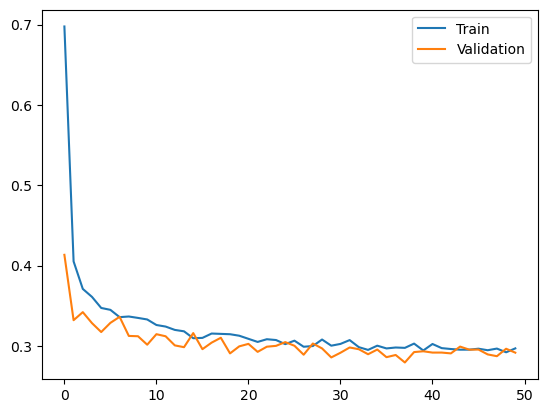

In [1316]:
plt.plot(train_report['train_loss_history'], label='Train')
plt.plot(train_report['val_loss_history'], label='Validation')
plt.legend()
plt.show()

## Evaluation

- Train data

In [1317]:
y_pred_train = model.predict(train_numeric_data, train_categorical_data, train_time_data, train_station_data)

Text(0.5, 1.0, 'y_true')

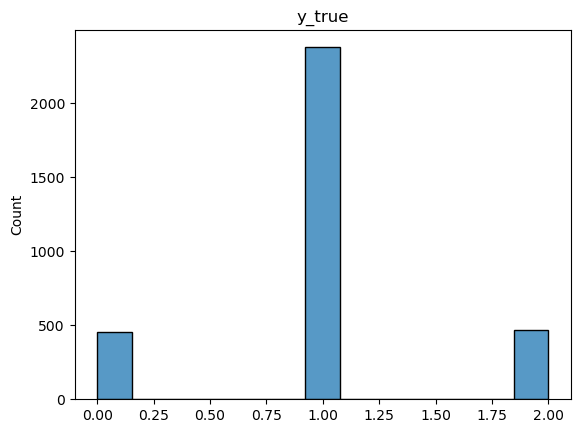

In [1318]:
sns.histplot(y_train)
plt.title('y_true')

Text(0.5, 1.0, 'y_pred')

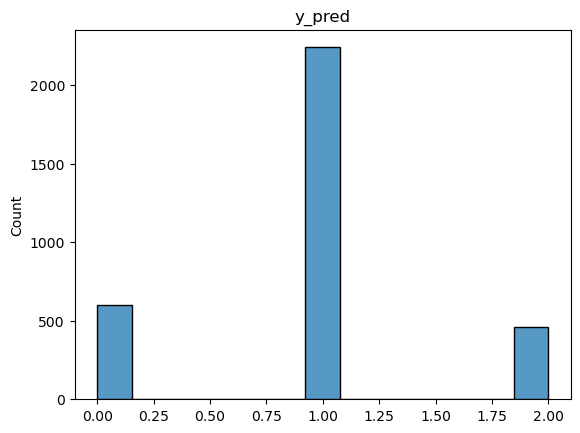

In [1319]:
sns.histplot(y_pred_train)
plt.title('y_pred')

In [1320]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.67      0.88      0.76       455
           1       0.93      0.88      0.90      2377
           2       0.79      0.78      0.78       467

    accuracy                           0.86      3299
   macro avg       0.80      0.84      0.81      3299
weighted avg       0.87      0.86      0.87      3299



- Validation data

In [1321]:
(0.80 + 0.84 + 0.81) / 3

0.8166666666666668

In [1322]:
y_pred_val = model.predict(val_numeric_data, val_categorical_data, val_time_data, val_station_data)

Text(0.5, 1.0, 'y_true val')

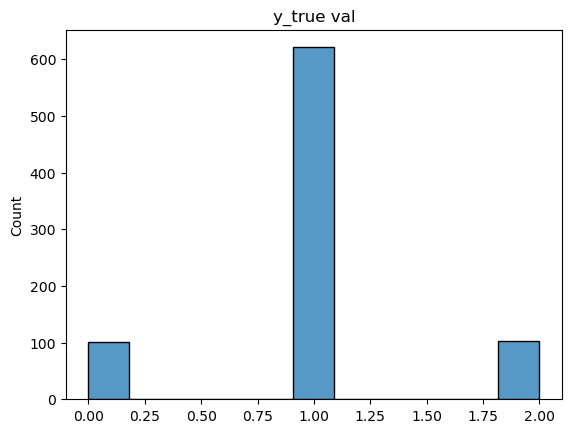

In [1323]:
sns.histplot(y_val)
plt.title('y_true val')

Text(0.5, 1.0, 'y_pred val')

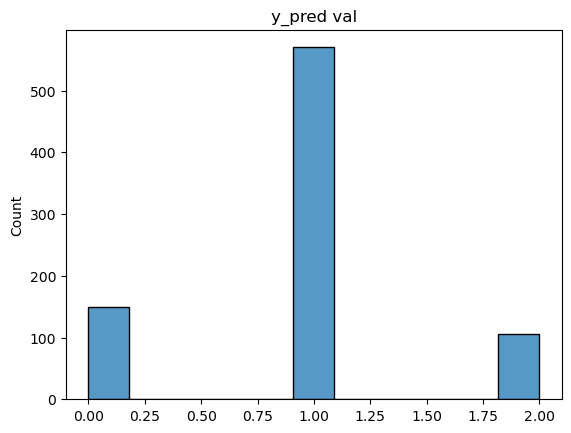

In [1324]:
sns.histplot(y_pred_val)
plt.title('y_pred val')

In [1325]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.60      0.89      0.72       101
           1       0.95      0.87      0.91       621
           2       0.80      0.83      0.81       103

    accuracy                           0.87       825
   macro avg       0.79      0.86      0.81       825
weighted avg       0.89      0.87      0.87       825



In [1326]:
(0.79 + 0.86 + 0.81) / 3

0.82

## Test data

In [1327]:
df_test = pd.read_csv(test_data)
df_test.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
1,2014,907,16,terraced,individual_heating,management_in_trust,90.0,1174.0,0~5min,0-5min,7.0,20.0,Myung-duk,9,14.0,17.0
2,2007,1629,7,terraced,individual_heating,management_in_trust,7.0,605.0,0~5min,0-5min,5.0,5.0,Banwoldang,5,9.0,5.0
3,2005,743,21,mixed,individual_heating,management_in_trust,67.0,798.0,0~5min,5min~10min,6.0,0.0,Bangoge,7,13.0,15.0
4,2006,903,7,terraced,individual_heating,management_in_trust,123.0,181.0,5min~10min,0-5min,3.0,11.0,Myung-duk,4,8.0,11.0


In [1328]:
X_test_prep = transformation_pipeline.transform(df_test)

In [1329]:
test_numeric_data = torch.tensor(X_test_prep[:, :10], dtype=torch.float)
test_time_data = torch.tensor(X_test_prep[:, 10:12], dtype=torch.float)
test_categorical_data = torch.tensor(X_test_prep[:, 12:-8], dtype=torch.float)
test_station_data = torch.tensor(X_test_prep[:, -8:], dtype=torch.float)

val_numeric_data = torch.tensor(X_val_prep[:, :10], dtype=torch.float)
val_time_data = torch.tensor(X_val_prep[:, 10:12], dtype=torch.float)
val_categorical_data = torch.tensor(X_val_prep[:, 12:-8], dtype=torch.float)


In [1330]:
y_test_pred = model.predict(test_numeric_data, test_categorical_data, test_time_data, test_station_data)

In [1331]:
Counter(y_test_pred)

Counter({1: 1221, 2: 228, 0: 318})

Text(0.5, 1.0, 'y_pred test')

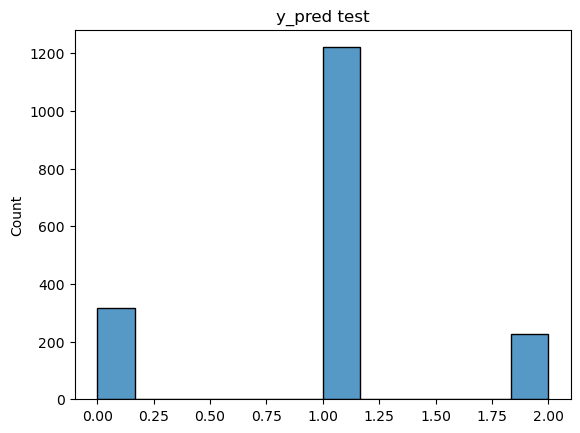

In [1332]:
sns.histplot(y_test_pred)
plt.title('y_pred test')